In [22]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "10_adv_problems/10c_gan.ipynb"
_nb_title = "GANs"
_nb_message = """
Train a vanilla and a deep convolutional GAN on MNIST.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=Generative Adversarial Networks (GANs)&url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fblob%2Fmaster%2F04_problem_types%2F04_generative_adversarial_networks.ipynb&download_url=https%3A%2F%2Fgithub.com%2FGoogleCloudPlatform%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F04_problem_types%2F04_generative_adversarial_networks.ipynb">
    <img src="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/logo-cloud.png"/> Run in AI Platform Notebook</a>
  </td>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/04_generative_adversarial_networks.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/GoogleCloudPlatform/practical-ml-vision-book/blob/master/04_problem_types/04_generative_adversarial_networks.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://raw.githubusercontent.com/GoogleCloudPlatform/practical-ml-vision-book/master/04_problem_types/04_generative_adversarial_networks.ipynb">
    <img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>


# Generative Adversarial Networks (GANs)

## Enable GPU
This notebook and pretty much every other notebook in this repository will run faster if you are using a GPU. 

On Colab:
* Navigate to Edit→Notebook Settings
* Select GPU from the Hardware Accelerator drop-down

On Cloud AI Platform Notebooks:
* Navigate to https://console.cloud.google.com/ai-platform/notebooks
* Create an instance with a GPU or select your instance and add a GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.3.0
Found GPU at: /device:GPU:0


In [3]:
# Import libraries and modules
import matplotlib.pyplot as plt
import numpy as np
print(np.__version__)
np.set_printoptions(threshold=np.inf)

1.18.5


## Vanilla GANs

For a vanilla GAN, we use just basic `Dense` layers for both the generator and discriminator.

In [4]:
# Create the generator.
latent_dim = 512
vanilla_generator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=28 * 28 * 1, activation="tanh"),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1))
    ],
    name="vanilla_generator"
)
vanilla_generator.summary()

Model: "vanilla_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)         

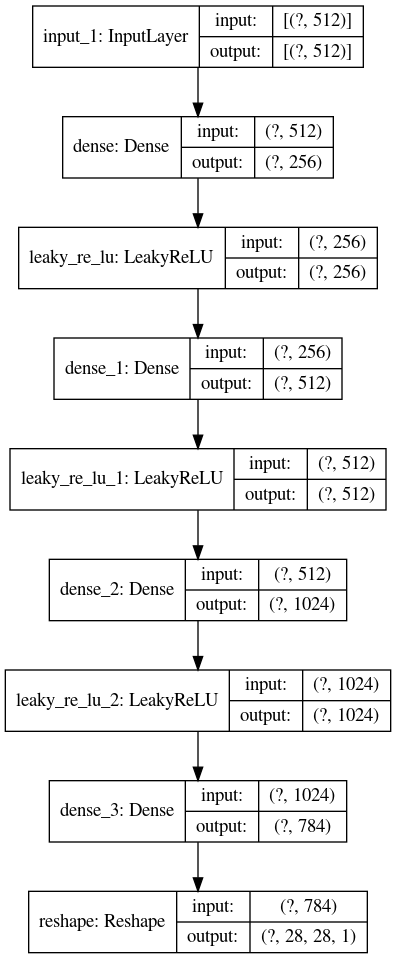

In [5]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=vanilla_generator,
    to_file="vanilla_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [6]:
# Create the discriminator.
vanilla_discriminator = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=512),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=256),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dense(units=1),
    ],
    name="vanilla_discriminator"
)
vanilla_discriminator.summary()

Model: "vanilla_discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)     

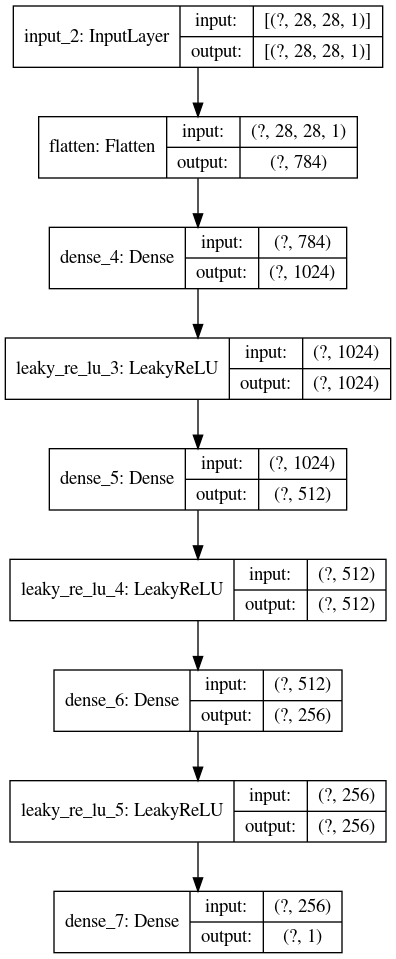

In [7]:
# Plot discriminator model.
tf.keras.utils.plot_model(
    model=vanilla_discriminator,
    to_file="vanilla_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

We'll create a custom `Model` class named `GAN` that we can use to facilitate training of our generator and discriminator networks.

In [8]:
class GAN(tf.keras.Model):
    """Custom model for training a GAN.

    Attributes:
        discriminator: Keras `Model`, the discriminator network.
        generator: Keras `Model`, the generator network.
        latent_dim: int, the latent vector dimension length.
        one_sided_label_smoothing: float, how much to smooth the real image
            labels by value in [0., 1.].
        discriminator_optimizer: Keras `Optimizer`, optimizer for
            discriminator network.
        generator_optimizer: Keras `Optimizer`, optimizer for generator
            network.
        loss_fn: Keras `Loss`, loss function for training both networks.
    """
    def __init__(
        self, discriminator, generator, latent_dim, one_sided_label_smoothing
    ):
        """Instantiates `GAN` model class.

        Args:
            discriminator: Keras `Model`, the discriminator network.
            generator: Keras `Model`, the generator network.
            latent_dim: int, the latent vector dimension length.
            one_sided_label_smoothing: float, how much to smooth the real image
                labels by value in [0., 1.].
        """
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.one_sided_label_smoothing = one_sided_label_smoothing

    def compile(self, discriminator_optimizer, generator_optimizer, loss_fn):
        """Overrides base `Model` class' compile method.

        Args:
            discriminator_optimizer: Keras `Optimizer`, optimizer for
                discriminator network.
            generator_optimizer: Keras `Optimizer`, optimizer for generator
                network.
            loss_fn: Keras `Loss`, loss function for training both networks.
        """
        super(GAN, self).compile()
        self.discriminator_optimizer = discriminator_optimizer
        self.generator_optimizer = generator_optimizer
        self.loss_fn = loss_fn

    def discriminator_train_step(self, batch_size, real_images):
        """Trains discriminator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.
            real_images: tensor, rank 4 tensor of real images with shape
                (batch_size, height, width, depth).

        Returns:
            discriminator_loss: tensor, scalar loss of disriminator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Generate images from noise.
        generated_images = self.generator(inputs=random_latent_vectors)

        # Combine generated images with real images.
        combined_images = tf.concat(
            values=[generated_images, real_images], axis=0
        )

        # Create fake and real labels.
        fake_labels = tf.zeros(shape=(batch_size, 1))
        real_labels = tf.ones(shape=(batch_size, 1))

        # Smooth real labels to help with training.
        real_labels *= self.one_sided_label_smoothing

        # Combine labels to be in-line with combined images.
        labels = tf.concat(
            values=[fake_labels, real_labels], axis=0
        )

        # Train ONLY the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(inputs=combined_images)
            discriminator_loss = self.loss_fn(
                y_true=labels, y_pred=predictions
            )

        grads = tape.gradient(
            target=discriminator_loss,
            sources=self.discriminator.trainable_weights
        )

        self.discriminator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.discriminator.trainable_weights)
        )

        return discriminator_loss

    def generator_train_step(self, batch_size):
        """Trains generator for one step.

        Args:
            batch_size: tensor, scalar tensor representing number of elements
                in the mini-batch.

        Returns:
            generator_loss: tensor, scalar loss of generator step.
        """
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Create labels as if they're real images.
        labels = tf.ones(shape=(batch_size, 1))

        # Train ONLY the generator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                inputs=self.generator(inputs=random_latent_vectors)
            )
            generator_loss = self.loss_fn(y_true=labels, y_pred=predictions)

        grads = tape.gradient(
            target=generator_loss, sources=self.generator.trainable_weights
        )

        self.generator_optimizer.apply_gradients(
            grads_and_vars=zip(grads, self.generator.trainable_weights)
        )

        return generator_loss

    def train_step(self, real_images):
        """Trains `GAN` for one step.

        Args:
            real_images: tensor, rank 4 tensor of real images with shape
                (batch_size, height, width, depth).

        Returns:
            losses: dict, dictionary of losses from each sub-training step.
        """
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get dynamic batch size to use for random noise vectors.
        batch_size = tf.shape(input=real_images)[0]

        # First train discriminator.
        discriminator_loss = self.discriminator_train_step(
            batch_size, real_images
        )

        # Then train generator.
        generator_loss = self.generator_train_step(batch_size)

        losses = {
            "discriminator_loss": discriminator_loss,
            "generator_loss": generator_loss
        }

        return losses


In [9]:
def create_train_dataset(batch_size):
    """Creates training dataset.

    Args:
        batch_size: int, number of elements in a mini-batch.

    Returns:
        dataset: `Dataset`, dataset object for training using MNIST.
    """
    # Get and format MNIST data.
    (x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

    # Let's combine both training and test sets.
    combined = np.concatenate([x_train, x_test])
    combined = (combined.astype("float32") - 127.5) / 255.0
    combined = np.reshape(combined, newshape=(-1, 28, 28, 1))

    # Create tf.data.Dataset for training.
    dataset = tf.data.Dataset.from_tensor_slices(tensors=combined)
    dataset = dataset.shuffle(buffer_size=70000).batch(batch_size=batch_size)

    return dataset


In [10]:
# Instantiate a GAN instance using our vanilla generator and discriminator.
vanilla_gan = GAN(
    discriminator=vanilla_discriminator,
    generator=vanilla_generator,
    latent_dim=latent_dim,
    one_sided_label_smoothing=0.9
)

vanilla_gan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# Train vanilla GAN model.
vanilla_gan_history = vanilla_gan.fit(
    create_train_dataset(batch_size=128), epochs=30
)

Epoch 1/30
547/547 [==============================] - 2s 4ms/step - discriminator_loss: 0.6181 - generator_loss: 1.4087
Epoch 2/30
547/547 [==============================] - 2s 4ms/step - discriminator_loss: 0.6057 - generator_loss: 1.3680
Epoch 3/30
547/547 [==============================] - 2s 4ms/step - discriminator_loss: 0.5793 - generator_loss: 1.4029
Epoch 4/30
547/547 [==============================] - 2s 4ms/step - discriminator_loss: 0.5959 - generator_loss: 1.2946
Epoch 5/30
547/547 [==============================] - 2s 4ms/step - discriminator_loss: 0.5994 - generator_loss: 1.2523
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - discriminator_loss: 0.5967 - generator_loss: 1.2620
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - discriminator_loss: 0.5946 - generator_loss: 1.2734
Epoch 8/30
547/547 [==============================] - 2s 4ms/step - discriminator_loss: 0.5902 - generator_loss: 1.2940
Epoch 9/30
547/547 [====================

Let's plot the loss history and some generated images using our trained model.

In [12]:
def plot_loss_history(history):
    """Plots loss history.

    Args:
        history: `keras.callbacks.History`, history object from training job.
    """
    plt.plot(history.history["generator_loss"])
    plt.plot(history.history["discriminator_loss"])
    plt.title("Training losses")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["generator", "discriminator"], loc="upper left")
    plt.show()


In [11]:
def plot_images(images):
    """Plots images.

    Args:
        images: np.array, array of images of
            [num_images, image_size, image_size, num_channels].
    """
    num_images = len(images)

    plt.figure(figsize=(20, 20))
    for i in range(num_images):
        image = images[i]
        plt.subplot(1, num_images, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(
            tf.reshape(image, image.shape[:-1]),
            cmap="gray_r"
        )
    plt.show()

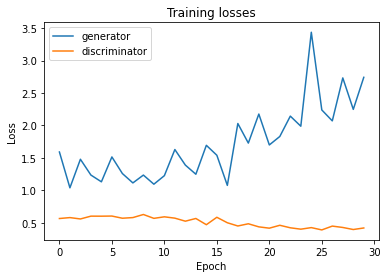

In [13]:
plot_loss_history(history=vanilla_gan_history)

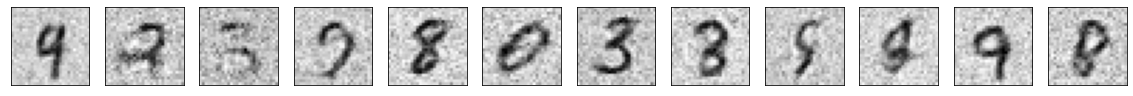

In [14]:
plot_images(
    images=vanilla_gan.generator(
        inputs=tf.random.normal(shape=(12, latent_dim))
    )
)

## DCGAN

A Deep-convolutional GAN (DCGAN) uses convolutional (`Conv2D`) and deconvolutional (`Conv2DTranspose`) instead of `Dense` layers for the discriminator and generator respectively.

In [15]:
# Create the generator
def create_generator_block(filters, kernel_size, strides, padding, alpha):
    """Creates generator block of layers.

    Args:
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        List of layers.
    """
    return [
        tf.keras.layers.Conv2DTranspose(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=alpha)
    ]

def create_dcgan_generator(latent_dim):
    """Creates deep convolutional GAN generator network.

    Args:
        latent_dim: int, the latent vector dimension length.

    Returns:
        Keras Sequential Model.
    """
    dcgan_generator = [
        tf.keras.Input(shape=(latent_dim,)),
        tf.keras.layers.Dense(units=7 * 7 * 256),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    ] + create_generator_block(
        filters=128, kernel_size=4, strides=2, padding="same", alpha=0.2
    ) + create_generator_block(
        filters=128, kernel_size=4, strides=2, padding="same", alpha=0.2
    ) + [
        tf.keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=3,
            strides=1,
            padding="same",
            activation="tanh"
        )
    ]

    return tf.keras.Sequential(layers=dcgan_generator, name="dcgan_generator")

dcgan_generator = create_dcgan_generator(latent_dim=512)
dcgan_generator.summary()

Model: "dcgan_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12544)             6435072   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       524416    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)   

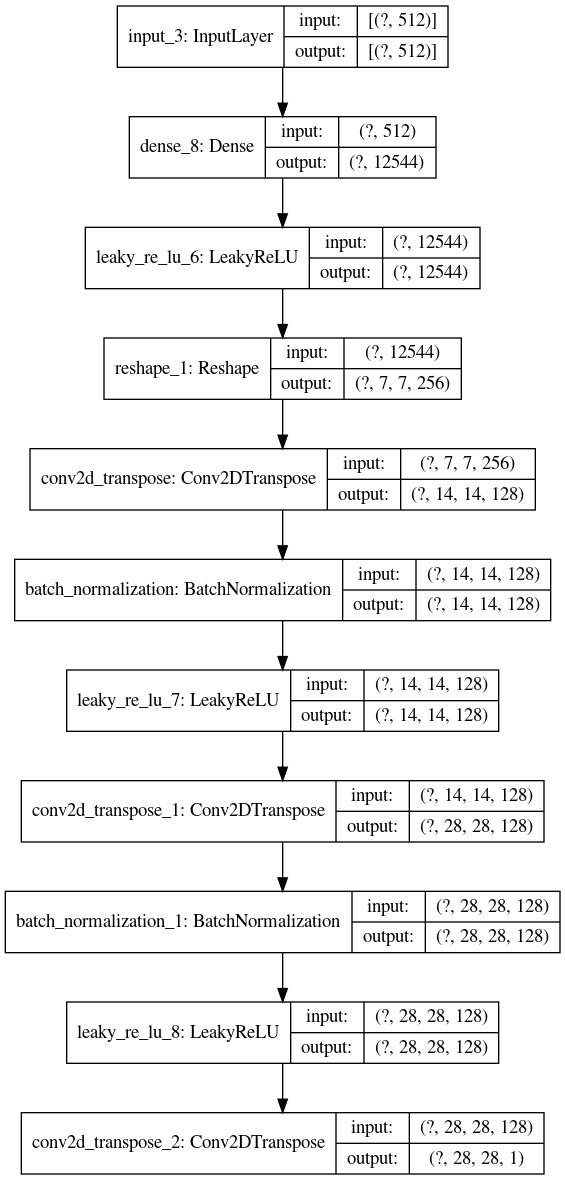

In [16]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_generator,
    to_file="dcgan_generator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [17]:
# Create the discriminator
def create_discriminator_block(filters, kernel_size, strides, padding, alpha):
    """Creates discriminator block of layers.

    Args:
        filters: int, number of output filters/channels.
        kernel_size: int/2-tuple of ints, the height and width of the kernel.
        strides: int/2-tuple of ints, the height and width of each stride of
            sliding window.
        padding: str, the type of padding of the output: same or valid.
        alpha: float, the amount of leakiness of LeakyRelu activations.

    Returns:
        List of layers.
    """
    return [
        tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            strides=strides,
            padding=padding
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(alpha=alpha)
    ]

def create_dcgan_discriminator(input_shape):
    """Creates deep convolutional GAN discriminator network.

    Args:
        input_shape: tuple, the shape of the input without batch dimension.

    Returns:
        Keras Sequential Model.
    """
    dcgan_discriminator = [
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(
            filters=64, kernel_size=3, strides=1, padding="same"
        ),
        tf.keras.layers.LeakyReLU(alpha=0.2)
    ] + create_discriminator_block(
        filters=128, kernel_size=3, strides=2, padding="same", alpha=0.2
    ) + create_discriminator_block(
        filters=128, kernel_size=3, strides=2, padding="same", alpha=0.2
    ) + create_discriminator_block(
        filters=256, kernel_size=3, strides=2, padding="same", alpha=0.2
    ) + [
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1)
    ]

    return tf.keras.Sequential(layers=dcgan_discriminator, name="dcgan_discriminator")

dcgan_discriminator = create_dcgan_discriminator(input_shape=(28, 28, 1))
dcgan_discriminator.summary()

Model: "dcgan_discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128) 

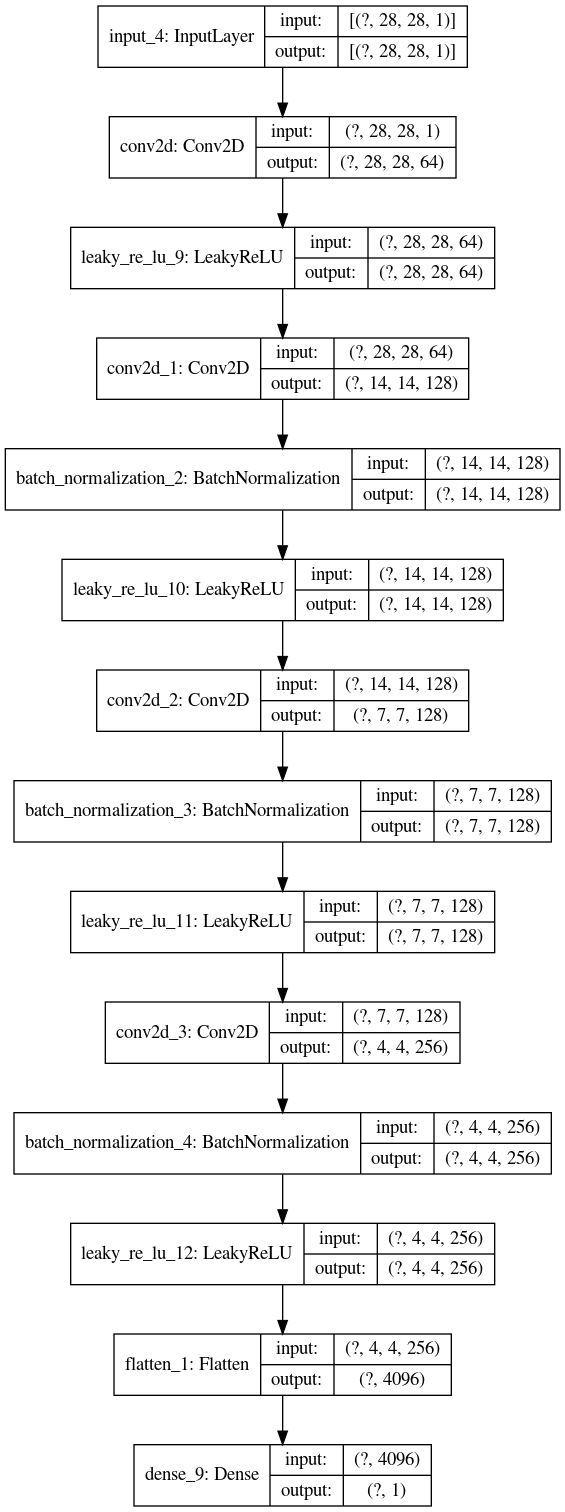

In [18]:
# Plot generator model.
tf.keras.utils.plot_model(
    model=dcgan_discriminator,
    to_file="dcgan_discriminator_model.png",
    show_shapes=True,
    show_layer_names=True
)

In [19]:
# Instantiate a GAN instance using our DCGAN generator and discriminator.
dcgan = GAN(
    discriminator=dcgan_discriminator,
    generator=dcgan_generator,
    latent_dim=latent_dim,
    one_sided_label_smoothing=0.9
)

dcgan.compile(
    discriminator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    generator_optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5, beta_2=0.999, epsilon=1e-8
    ),
    loss_fn=tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

# Train DCGAN model.
dcgan_history = dcgan.fit(create_train_dataset(batch_size=128), epochs=50)

Epoch 1/50
547/547 [==============================] - 52s 95ms/step - discriminator_loss: 0.5344 - generator_loss: 1.3797
Epoch 2/50
547/547 [==============================] - 51s 94ms/step - discriminator_loss: 0.4646 - generator_loss: 1.7334
Epoch 3/50
547/547 [==============================] - 52s 94ms/step - discriminator_loss: 0.4697 - generator_loss: 1.7260
Epoch 4/50
547/547 [==============================] - 51s 94ms/step - discriminator_loss: 0.4705 - generator_loss: 1.7459
Epoch 5/50
547/547 [==============================] - 52s 94ms/step - discriminator_loss: 0.4673 - generator_loss: 1.7684
Epoch 6/50
547/547 [==============================] - 52s 95ms/step - discriminator_loss: 0.4675 - generator_loss: 1.7803
Epoch 7/50
547/547 [==============================] - 52s 94ms/step - discriminator_loss: 0.4517 - generator_loss: 1.8999
Epoch 8/50
547/547 [==============================] - 52s 94ms/step - discriminator_loss: 0.4392 - generator_loss: 2.0122
Epoch 9/50
547/547 [====

Let's plot the loss history and some generated images using our trained model.

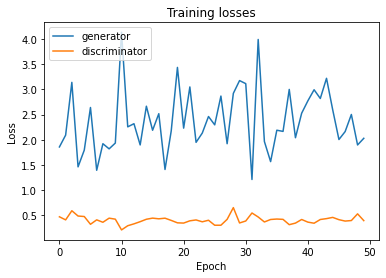

In [20]:
plot_loss_history(history=dcgan_history)

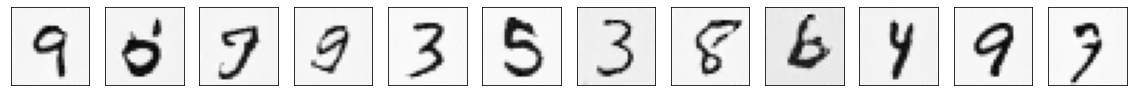

In [21]:
plot_images(
    images=dcgan.generator(inputs=tf.random.normal(shape=(12, latent_dim)))
)